In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string
import pandas as pd

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'14'}

# Heater simulation for tapes 35, 36, 37

- The results from the heater experiments are plotted
- The heater used for these results is H2 located between sections V6 and V7.
- The peak voltages are choosen with the same time stamp where the voltage in V7 has its maximum value
- Transport current applied to the tape was 80 A. 
- Different voltage levels of the heater were used for each tape before and after the coating.


In [2]:
# main reads the data from csv file and plots it, it also saves the voltage profiles in a text file
def main(file_csv,tape_number,Vheater,filenumber,current_percent,filename,coating):
    # Uploading data from csv file
    data_ic_wo = pd.read_csv(file_csv)
    #time_ic_wo = data_ic_wo['time']
    
    # Creating time array from data using the sampling rate from CDAQ 0.19984 s
    last_index = len(data_ic_wo['v7_m']) 
    stop = (last_index)*(0.19984) 
    time_ic_wo = np.arange(0,stop,0.19984)
    
    # For loop to print the voltages from the 12 sections
    fig,ax = plt.subplots()
    for i in range(12): 
        v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
        ax.plot(time_ic_wo,(v_wo-v_wo[0])/1e-3,label = f'V{i+1}')

    ax.set_xlabel('Time (s)',**axis_font)
    ax.set_ylabel('Voltage (mV)',**axis_font)
    ax.set_ylim(-1,7)
    ax.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'size':10}) 
    ax.grid()

    ax2 = ax.twinx()
    ax2.plot(time_ic_wo,data_ic_wo['T2_m'],'--k')
    ax2.set_ylabel('Temperature (K)',**axis_font)
    ax2.set_ylim(70,450)
    plt.title(f'Tape {tape_number} '+coating+f' VOx coating {current_percent} A, heater {Vheater} V',**axis_font)
    plt.tight_layout()
    plt.show()
    
    # Selecting the index where V7_m has its maximum value
    max_T, max_index =  max(data_ic_wo['v7_m']), np.where(data_ic_wo['v7_m'] == max(data_ic_wo['v7_m']))[0][0]
    print(f'V_heater',Vheater,': Max V7 =',max_T,'V, index',max_index)

    # Saving voltage profile 
    if filenumber<1:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        print(max_V)
        # Saving data from average and sd arrays
        with open(filename, 'w') as output:
            output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')
    else:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        print(max_V)
        # Saving data from average and sd arrays
        #filename = f'Tape {tape_number} heater {current_percent} peak voltages without coating.txt'
        with open(filename, 'a') as output:
            #output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')

# Definition to plot the voltage profile
def v_profile_plot(filename):
        
    data_wo = read_file(filename) # Peak voltages without coating
    
    section = np.arange(12)+1
    fig,ax = plt.subplots()
    
    for i in range(len(data_wo)):
        plt.plot(section,data_wo[i][:-1]/1E-3,'-s',label = coating+f'_VOx {data_wo[i][-1]}V')

    #for i in range(len(data_w)):
    #    plt.plot(data_w[i][:-1]/1E-6,'-o',label = f'w_VOx {data_w[i][-1]}V')
    
    ax.set_ylim(-0.2,7)     
    ax.set_xlabel('Section',**axis_font)
    ax.set_ylabel('Peak voltage (mV)',**axis_font)
    ax.set_title(f'Heater ({current_percent}) tape {tape_number}',**axis_font)
    ax.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'heater_t{tape_number}_{current_percent}_maxv7_'+coating+'.png')
    plt.show()

# Definition to read data from txt file with voltage profile 
def read_file(filename):
    with open(filename) as f:
        lines_after_first = f.readlines()[1:]
        data = []
        for line in lines_after_first:
            tmp = [float(x) for x in line.split('\t')]
            data.append(tmp)
    data = np.asanyarray(data)
    return data

In [3]:
# Definition to plot voltage profile before and after coating together
def v_profile_plot2(filename,coating):
        
    data_wo = read_file(filename) # Peak voltages without coating
    
    section = np.arange(12)+1
    #fig,ax = plt.subplots()
    
    for i in range(len(data_wo)):
        plt.plot(section,data_wo[i][:-1]/1E-3,'-s',label = coating+f'_VOx {data_wo[i][-1]}V')

    #for i in range(len(data_w)):
    #    plt.plot(data_w[i][:-1]/1E-6,'-o',label = f'w_VOx {data_w[i][-1]}V')
    
    ax.set_ylim(-0.2,7)     
    ax.set_xlabel('Section',**axis_font)
    ax.set_ylabel('Peak voltage (mV)',**axis_font)
    ax.set_title(f'Heater ({current_percent}) tape {tape_number}',**axis_font)
    ax.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
    plt.tight_layout()
    plt.grid()
    plt.savefig(f'heater_t{tape_number}_{current_percent}_maxv7_'+coating+'.png')
    #plt.show()

# Results from tape 35 without coating

<IPython.core.display.Javascript object>


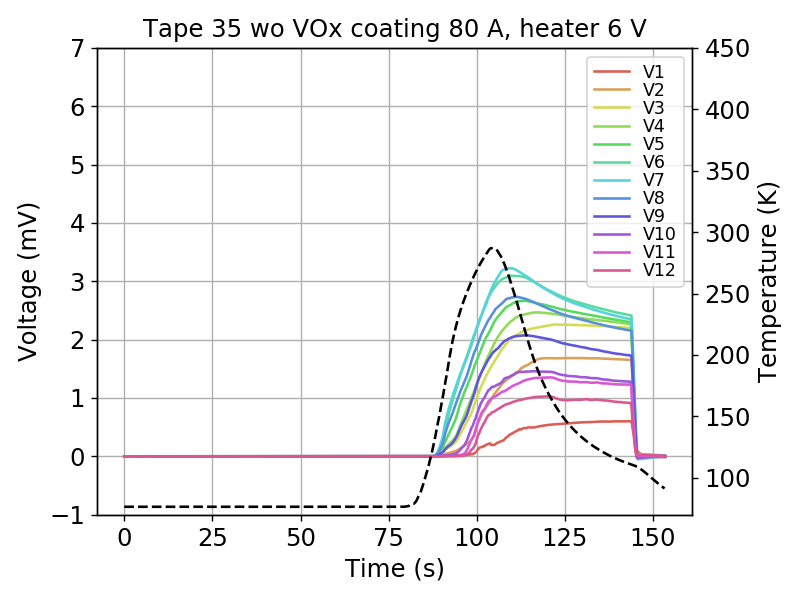

V_heater 6 : Max V7 = 0.0032115159999999998 V, index 547
[0.00036766 0.00134434 0.00200276 0.0022916  0.00258981 0.00308892
 0.00322492 0.00270879 0.00202471 0.00136458 0.00116969 0.00090641]


<IPython.core.display.Javascript object>


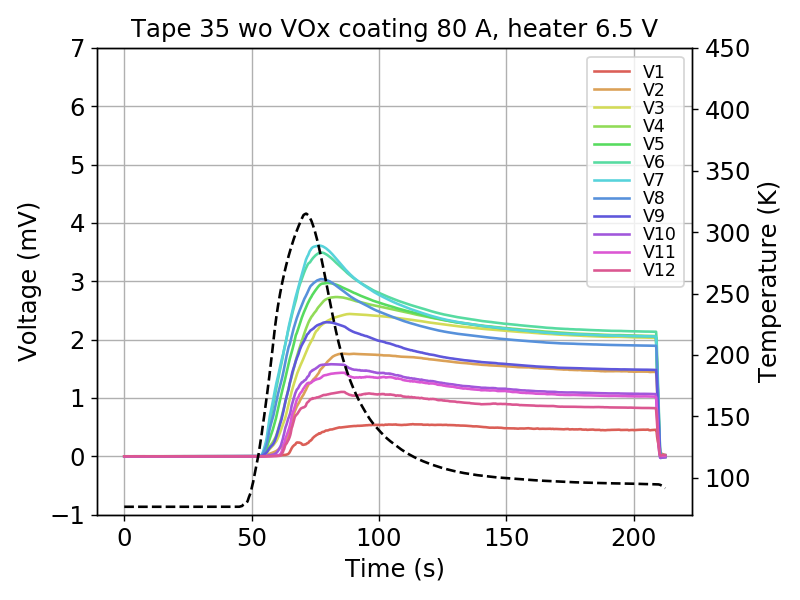

V_heater 6.5 : Max V7 = 0.003599159 V, index 383
[0.00039527 0.0014427  0.00220796 0.00257313 0.00292616 0.00348481
 0.00361226 0.00302916 0.00225956 0.00155095 0.00133111 0.00101966]


<IPython.core.display.Javascript object>


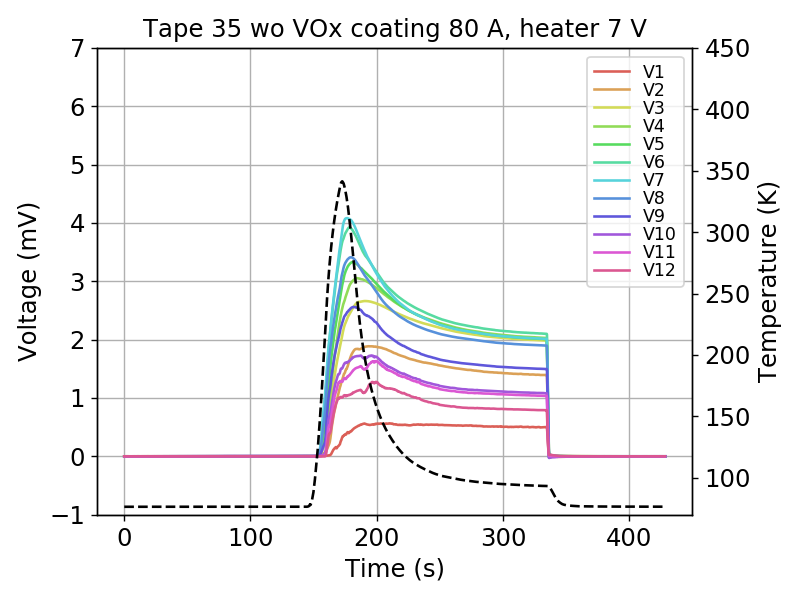

V_heater 7 : Max V7 = 0.004069527 V, index 884
[0.00040362 0.0015267  0.0023637  0.00281795 0.00323409 0.00388165
 0.00408283 0.00336852 0.00247355 0.00161286 0.00136446 0.00104652]


<IPython.core.display.Javascript object>


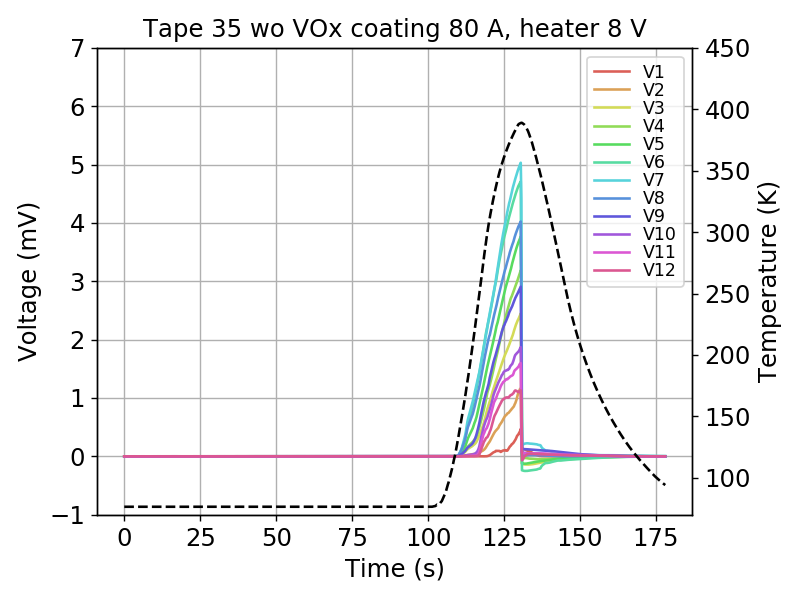

V_heater 8 : Max V7 = 0.00501807 V, index 653
[0.00047016 0.00116292 0.00244667 0.00318584 0.00376525 0.00471013
 0.00503147 0.0040237  0.00290766 0.0018706  0.00159777 0.0011308 ]


<IPython.core.display.Javascript object>


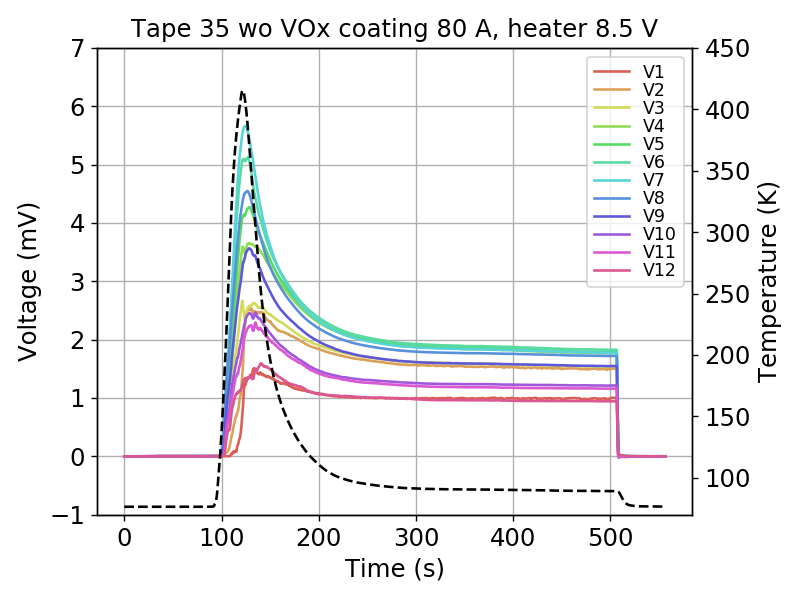

V_heater 8.5 : Max V7 = 0.005648657 V, index 624
[0.00123772 0.00232889 0.00235444 0.00350388 0.00415135 0.00506519
 0.00566176 0.00452059 0.00345815 0.00234586 0.00211162 0.00133433]


<IPython.core.display.Javascript object>


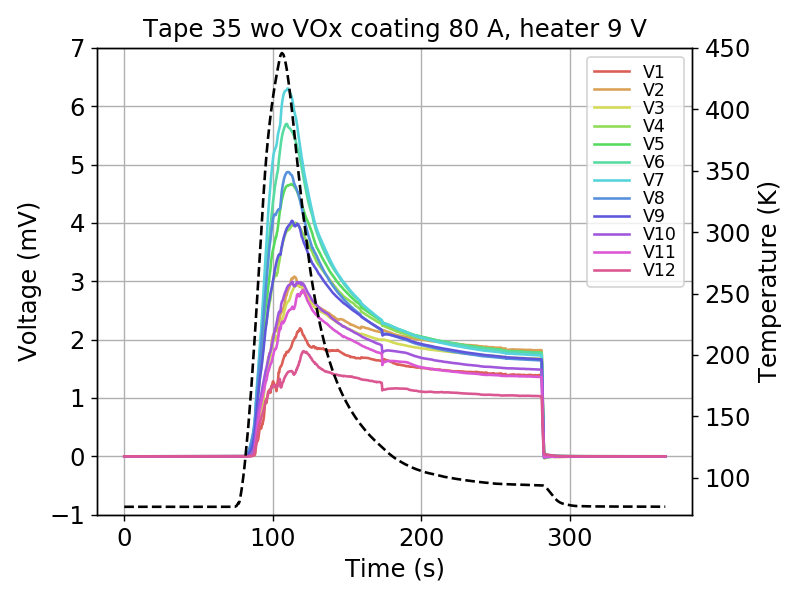

V_heater 9 : Max V7 = 0.0062932280000000005 V, index 551
[0.00178445 0.00283814 0.00264404 0.00387276 0.00463973 0.00565955
 0.00630643 0.00487113 0.00393562 0.00290953 0.00246403 0.00143434]


<IPython.core.display.Javascript object>


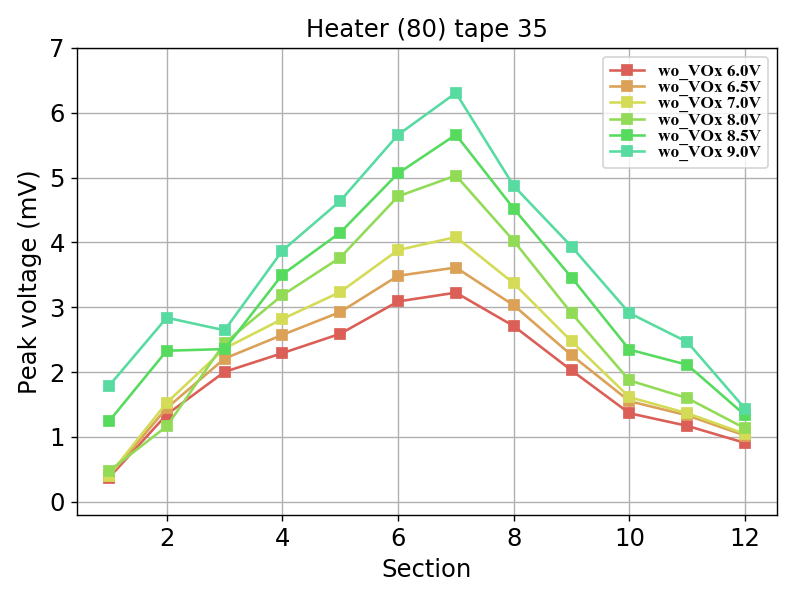

In [5]:
%matplotlib notebook
sns.set_palette(sns.color_palette("hls", 12))
tape_number = 35
current_percent = 80 # Transport current applied to the tape
coating = 'wo' # without coating 
filename = f'Tape {tape_number} heater {current_percent} A peak voltages without coating.txt'

Vheater = [6,6.5,7,8,8.5,9]
file_csv = [
'tape35_w_cu_thin29_2020-02-07-15-10-13.csv',
'tape35_w_cu_thin29_2020-02-07-15-23-09.csv',
'tape35_w_cu_thin29_2020-02-07-15-34-20.csv',
'tape35_w_cu_thin29_2020-02-07-15-44-33.csv',
'tape35_w_cu_thin29_2020-02-07-15-53-26.csv',
'tape35_w_cu_thin29_2020-02-07-16-37-08.csv'
]


for i in range(len(file_csv)):
    filenumber = i
    main(file_csv[i],tape_number,Vheater[i],filenumber,current_percent,filename,coating)
    
    
v_profile_plot(filename)

# Results from tape 36 before and after coating

<IPython.core.display.Javascript object>


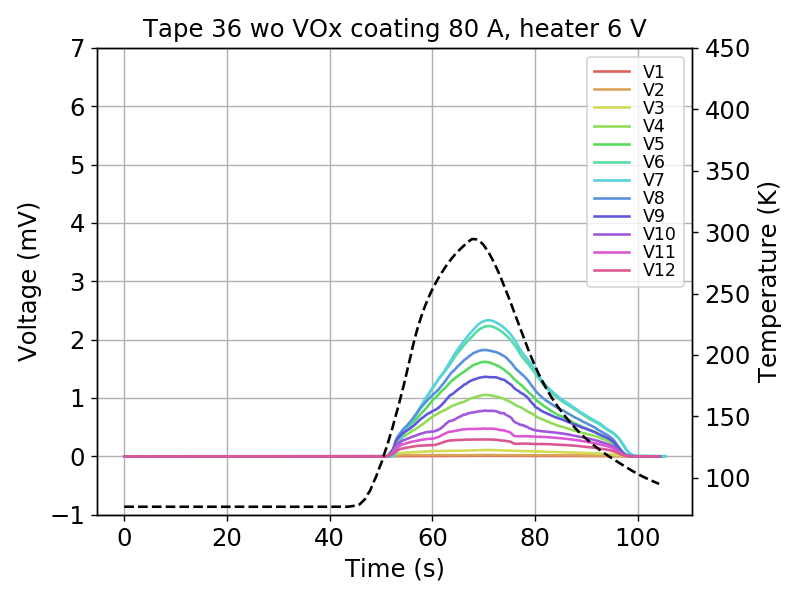

V_heater 6 : Max V7 = 0.002320245 V, index 355
[1.053000e-05 2.220000e-05 1.094720e-04 1.048063e-03 1.609659e-03
 2.233157e-03 2.333145e-03 1.813975e-03 1.357291e-03 7.766040e-04
 4.718100e-04 2.880290e-04]


<IPython.core.display.Javascript object>


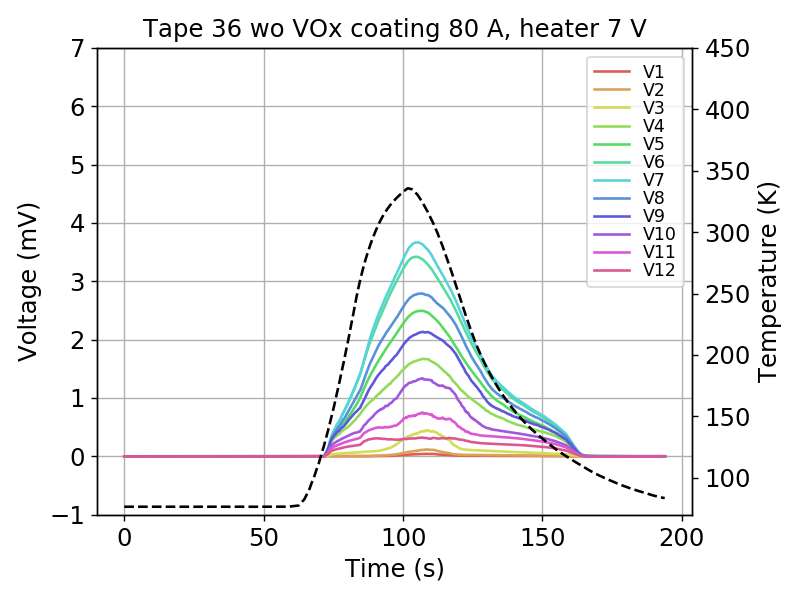

V_heater 7 : Max V7 = 0.003654225 V, index 526
[3.620000e-05 9.590000e-05 3.966260e-04 1.642169e-03 2.486832e-03
 3.420017e-03 3.666925e-03 2.780074e-03 2.104118e-03 1.309192e-03
 7.189040e-04 3.140010e-04]


<IPython.core.display.Javascript object>


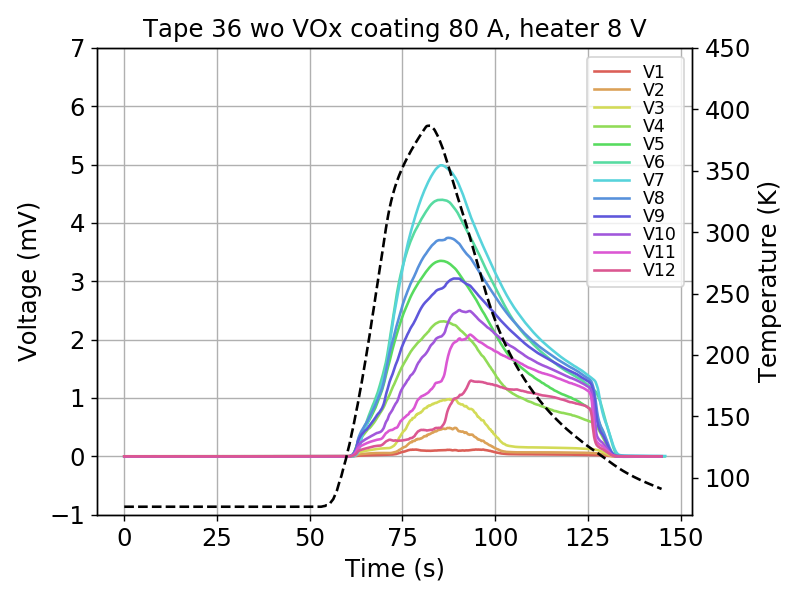

V_heater 8 : Max V7 = 0.0049751940000000005 V, index 427
[0.0001034  0.00045998 0.00095079 0.00231035 0.00335043 0.00439567
 0.00498829 0.00370443 0.00287202 0.00205178 0.00128073 0.00049017]


<IPython.core.display.Javascript object>


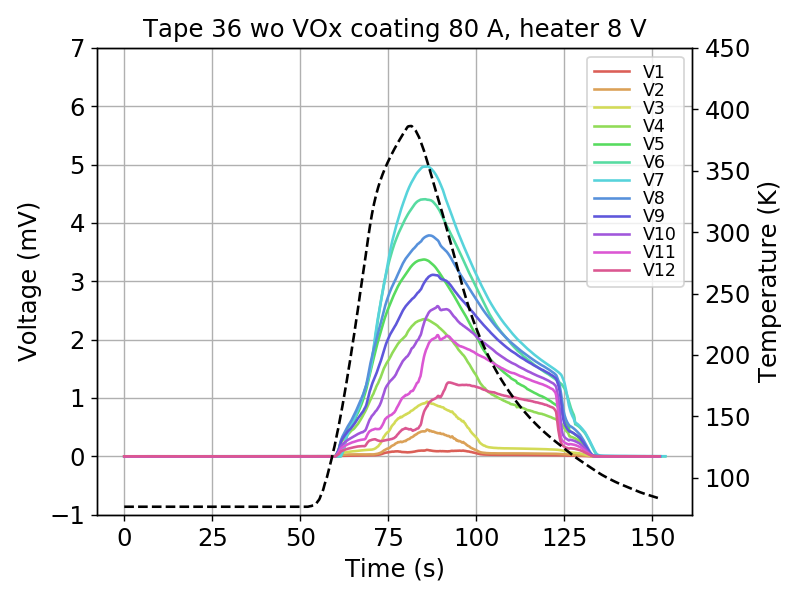

V_heater 8 : Max V7 = 0.00495766 V, index 431
[0.000109   0.00045724 0.00093641 0.0023404  0.00335749 0.00439752
 0.00497046 0.00377562 0.00305035 0.00242025 0.00188133 0.00085958]


<IPython.core.display.Javascript object>


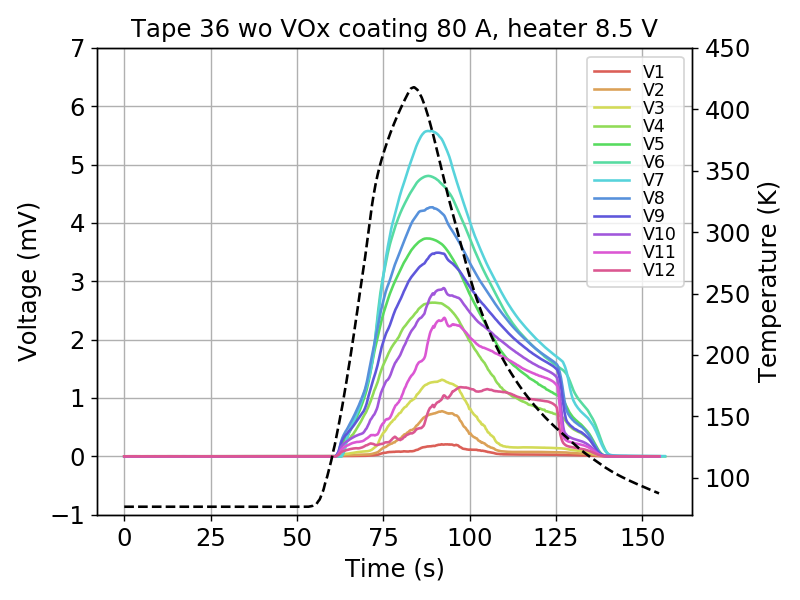

V_heater 8.5 : Max V7 = 0.005563775 V, index 440
[0.0001701  0.0007036  0.00124428 0.00262278 0.00373369 0.0048058
 0.00557658 0.00424874 0.00338674 0.00262067 0.00195225 0.00075315]


<IPython.core.display.Javascript object>


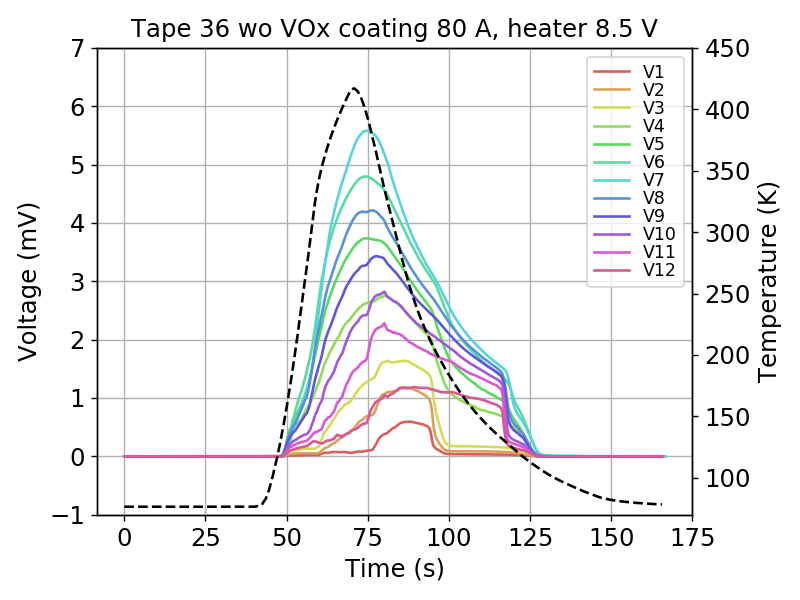

V_heater 8.5 : Max V7 = 0.0055683980000000004 V, index 372
[9.180000e-05 6.754760e-04 1.263813e-03 2.619989e-03 3.737450e-03
 4.795601e-03 5.581098e-03 4.185125e-03 3.271248e-03 2.417187e-03
 1.641234e-03 5.616940e-04]


<IPython.core.display.Javascript object>


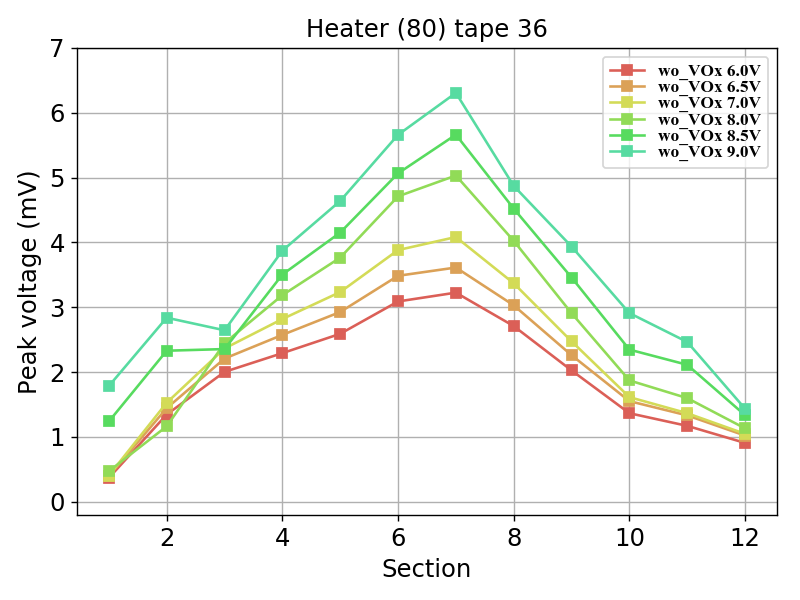

In [6]:
tape_number = 36
current_percent = 80 # transport current applied to the tape
coating = 'wo' # without coating
filename_wo = f'Tape {tape_number} heater {current_percent} A peak voltages without coating.txt'

Vheater = [6,7,8,8,8.5,8.5]
file_csv = [
'tape36_w_cu_thin_2020-02-10-16-10-57.csv',
'tape36_w_cu_thin_2020-02-10-17-21-44.csv',
'tape36_w_cu_thin_2020-02-10-15-47-46.csv',
'tape36_w_cu_thin_2020-02-10-16-00-54.csv',
'tape36_w_cu_thin_2020-02-10-15-24-38.csv',
'tape36_w_cu_thin_2020-02-10-15-37-11.csv'
]


for i in range(len(file_csv)):
    filenumber = i
    main(file_csv[i],tape_number,Vheater[i],filenumber,current_percent,filename_wo,coating)
    
    
v_profile_plot(filename)

<IPython.core.display.Javascript object>


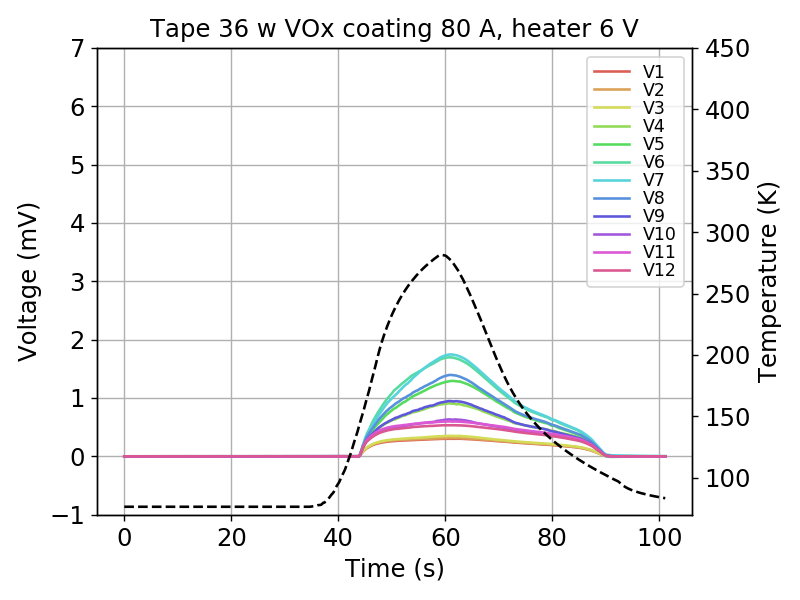

V_heater 6 : Max V7 = 0.00173292 V, index 305
[0.00030206 0.00031272 0.00035008 0.00090535 0.00129027 0.00169629
 0.00174612 0.00139453 0.00094655 0.00063252 0.00059806 0.00053383]


<IPython.core.display.Javascript object>


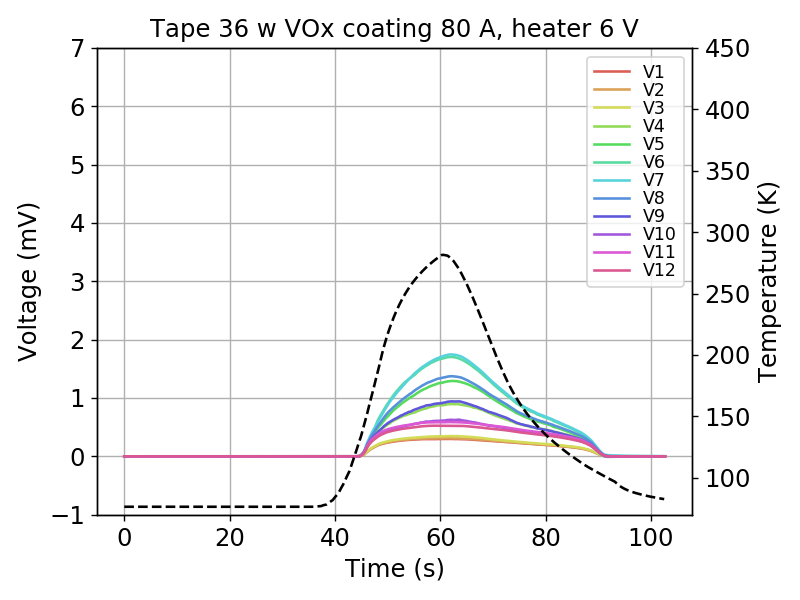

V_heater 6 : Max V7 = 0.00173382602410013 V, index 310
[0.0002982  0.00030879 0.00034609 0.00089372 0.00129034 0.00170391
 0.00174702 0.001372   0.00094051 0.00062563 0.0005867  0.00052472]


<IPython.core.display.Javascript object>


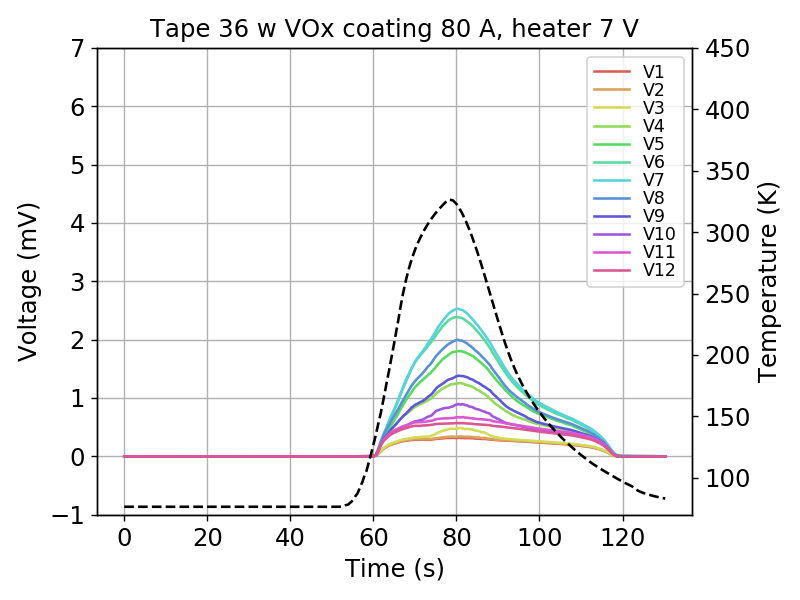

V_heater 7 : Max V7 = 0.00251330262116135 V, index 403
[0.00031682 0.00034145 0.00048382 0.00125441 0.00180421 0.00238467
 0.00252661 0.0019933  0.00138212 0.00089514 0.0006719  0.00056945]


<IPython.core.display.Javascript object>


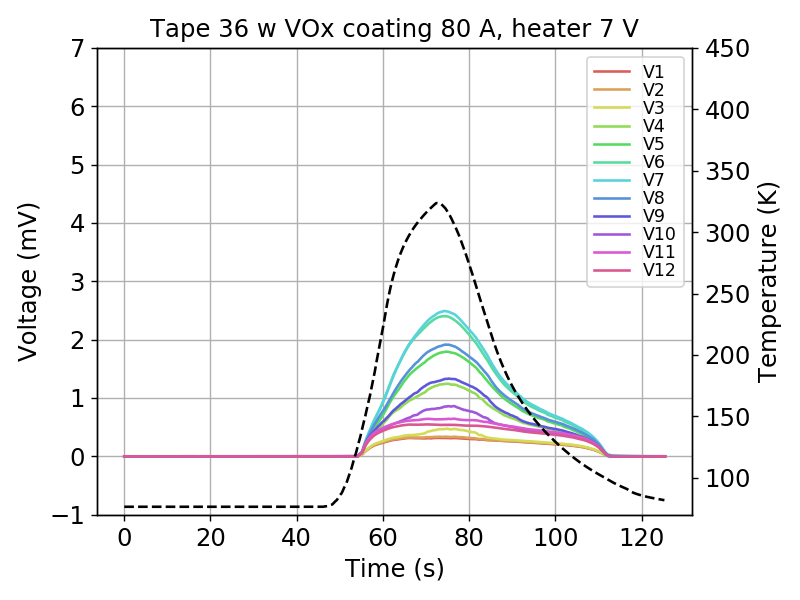

V_heater 7 : Max V7 = 0.00247772962502226 V, index 372
[0.00031243 0.00033389 0.0004674  0.0012414  0.0017903  0.00240215
 0.00249127 0.00191371 0.00132509 0.00085366 0.00063844 0.00053994]


<IPython.core.display.Javascript object>


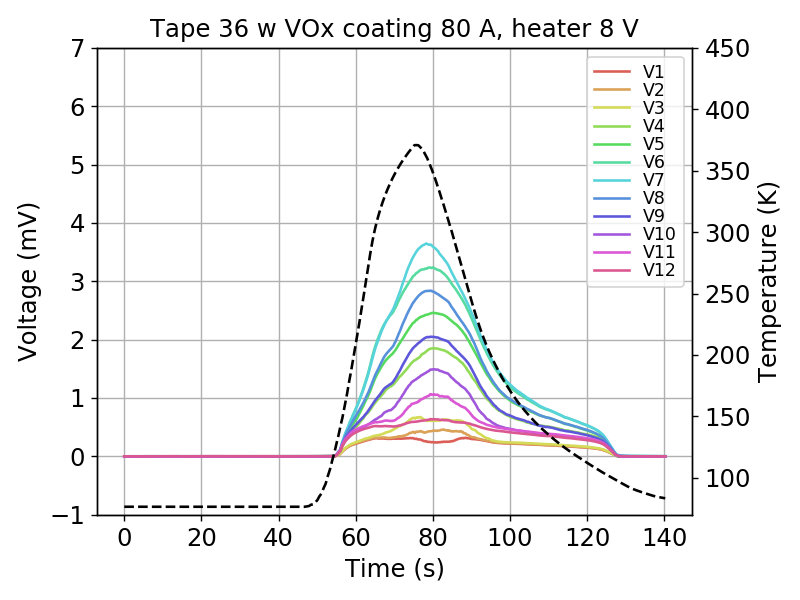

V_heater 8 : Max V7 = 0.0036337133296165 V, index 392
[0.00025626 0.00041604 0.00061522 0.00180052 0.00242509 0.00321562
 0.00364728 0.00283241 0.00203841 0.00143705 0.00101997 0.00062125]


<IPython.core.display.Javascript object>


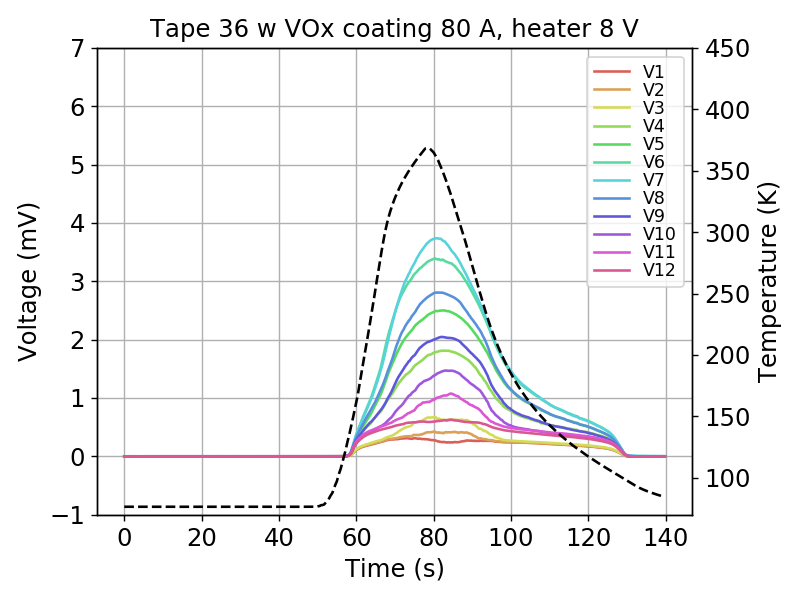

V_heater 8 : Max V7 = 0.0037243632469988 V, index 404
[0.00026447 0.00040699 0.0006522  0.00178901 0.00249249 0.00338069
 0.00373771 0.00280639 0.00201981 0.00140722 0.00100394 0.00060386]


C:\Users\acaraujomartinez\Anaconda\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


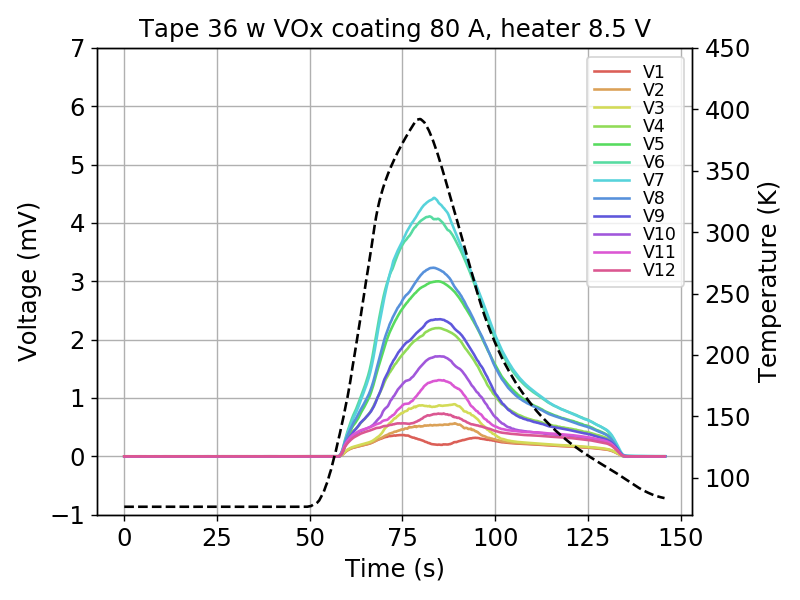

V_heater 8.5 : Max V7 = 0.00441792018897308 V, index 418
[0.00020431 0.00053696 0.00085046 0.00219345 0.00299184 0.00406272
 0.00443105 0.00322875 0.00234033 0.00170209 0.00129037 0.00072563]


<IPython.core.display.Javascript object>


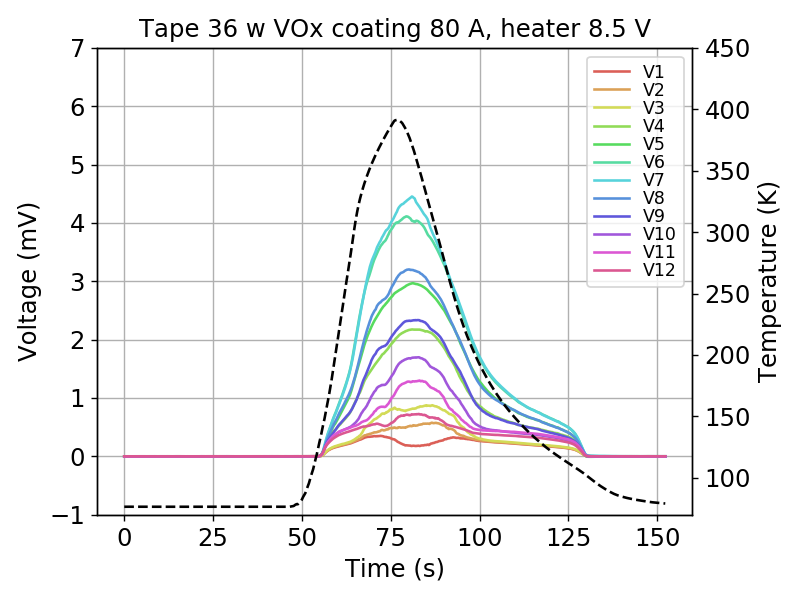

V_heater 8.5 : Max V7 = 0.004439259872782071 V, index 405
[0.00017769 0.00051645 0.00081254 0.00217381 0.00296442 0.00403968
 0.00445254 0.00319497 0.00232609 0.00168653 0.00127668 0.00072042]


<IPython.core.display.Javascript object>


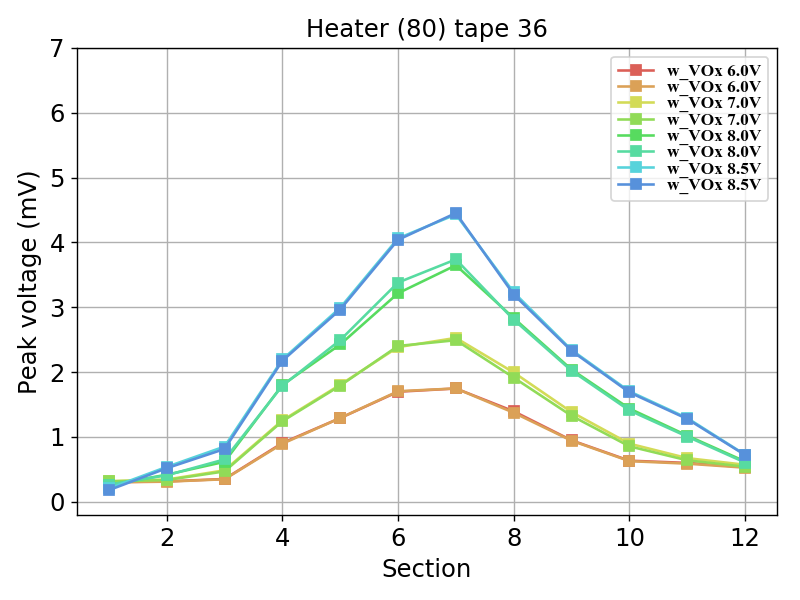

In [7]:
#%matplotlib notebook
tape_number = 36
current_percent = 80
coating = 'w' # with coating
filename_w = f'Tape {tape_number} heater {current_percent} A peak voltages with coating.txt'

Vheater = [6,6,7,7,8,8,8.5,8.5]
file_csv = [
'tape36_w_cu_coating_2020-02-12-13-36-18.csv',
'tape36_w_cu_coating_2020-02-12-13-49-37.csv',
'tape36_w_cu_coating_2020-02-12-14-01-48.csv',
'tape36_w_cu_coating_2020-02-12-14-15-24.csv',
'tape36_w_cu_coating_2020-02-12-14-30-05.csv',
'tape36_w_cu_coating_2020-02-12-14-53-43.csv',
'tape36_w_cu_coating_2020-02-12-15-22-52.csv',
'tape36_w_cu_coating_2020-02-12-15-46-46.csv'
]
 # 'tape36_w_cu_coating_2020-02-12-15-06-43.csv', 8.5 V (This file gives weird results)

for i in range(len(file_csv)):
    filenumber = i
    main(file_csv[i],tape_number,Vheater[i],filenumber,current_percent,filename_w,coating)
    
    
v_profile_plot(filename_w)

<IPython.core.display.Javascript object>


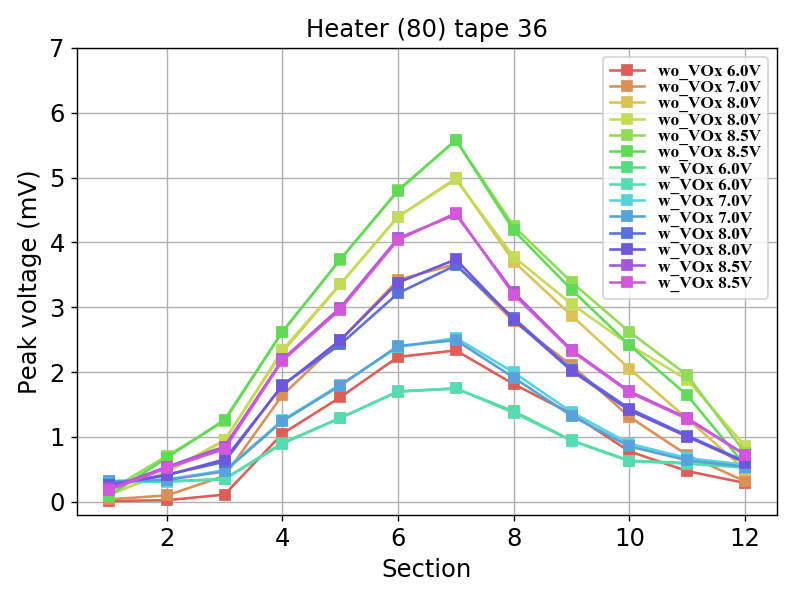

In [8]:
sns.set_palette(sns.color_palette("hls", 16))
fig,ax = plt.subplots()
v_profile_plot2(filename_wo,'wo')
v_profile_plot2(filename_w,'w')
plt.grid()
plt.show()

# Results for tape 37 before and after coating

<IPython.core.display.Javascript object>


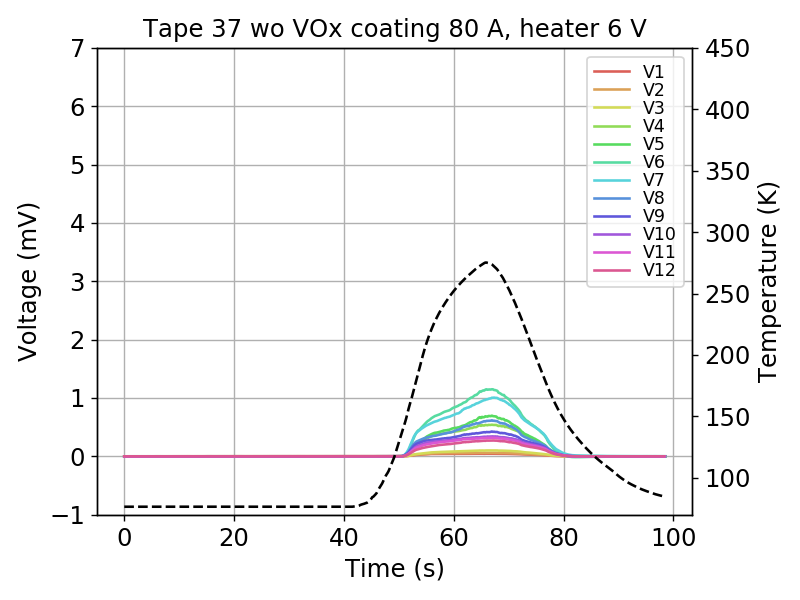

V_heater 6 : Max V7 = 0.000993482400854856 V, index 337
[4.39630433e-05 5.75077493e-05 1.00134441e-04 5.38143878e-04
 6.87150762e-04 1.13595317e-03 1.00627596e-03 6.10205318e-04
 4.21784997e-04 3.38286754e-04 3.17199569e-04 2.70859928e-04]


<IPython.core.display.Javascript object>


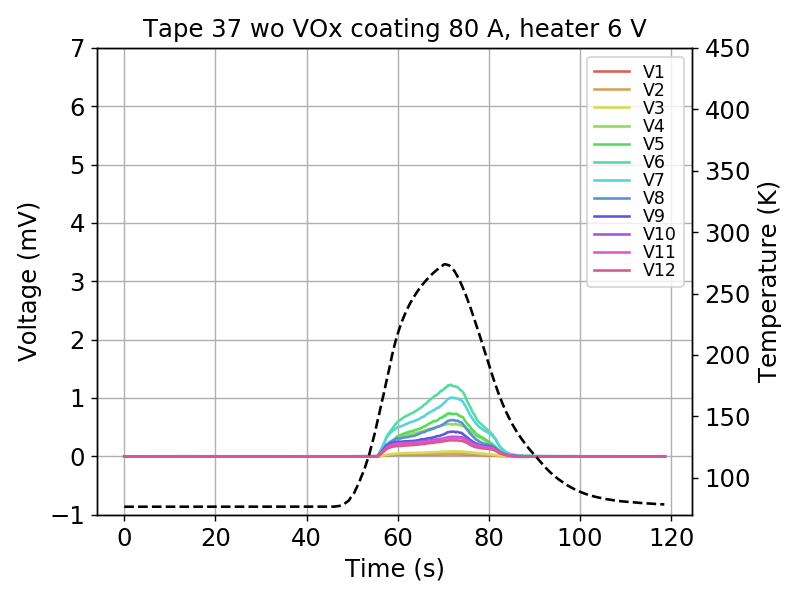

V_heater 6 : Max V7 = 0.000994780789039984 V, index 359
[3.46286683e-05 4.66912491e-05 8.36108880e-05 5.49126663e-04
 7.30549028e-04 1.22619989e-03 1.00807552e-03 6.23361629e-04
 4.21910278e-04 3.35066508e-04 3.19686646e-04 2.75712935e-04]


<IPython.core.display.Javascript object>


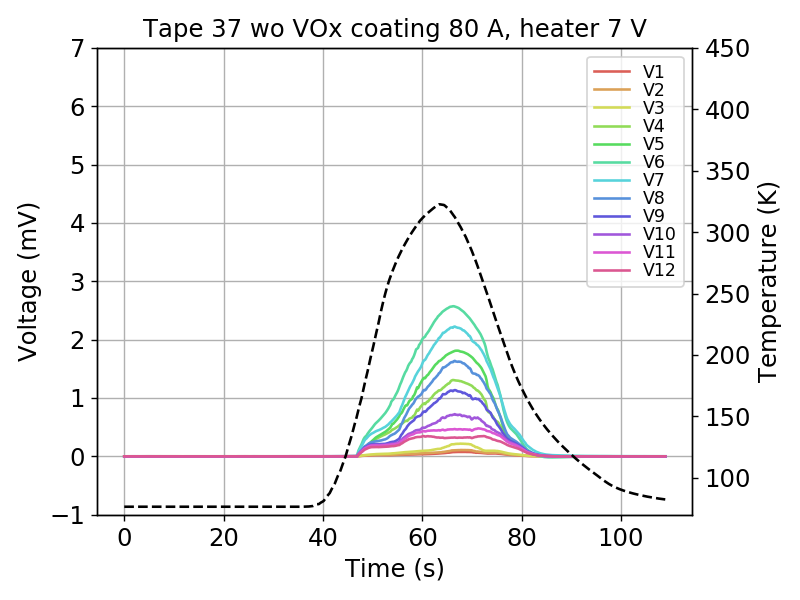

V_heater 7 : Max V7 = 0.00221170563893756 V, index 333
[7.29993671e-05 1.03382632e-04 2.10260594e-04 1.30196672e-03
 1.80709006e-03 2.56792034e-03 2.22491734e-03 1.63631809e-03
 1.13510827e-03 7.22732613e-04 4.68112805e-04 3.23300620e-04]


<IPython.core.display.Javascript object>


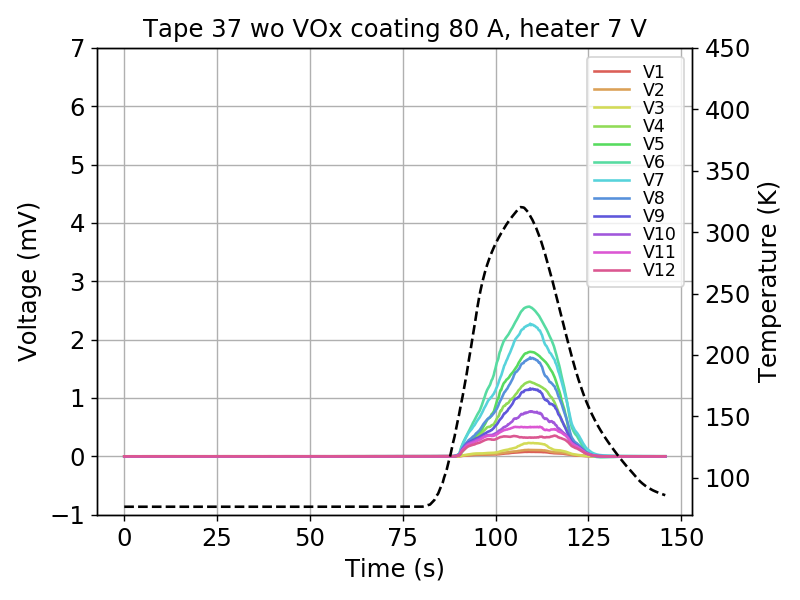

V_heater 7 : Max V7 = 0.0022589966901748197 V, index 547
[7.69358492e-05 1.08673661e-04 2.27605077e-04 1.27805258e-03
 1.79105629e-03 2.55784390e-03 2.27277328e-03 1.69552381e-03
 1.16371069e-03 7.68530761e-04 5.05442916e-04 3.23481472e-04]


<IPython.core.display.Javascript object>


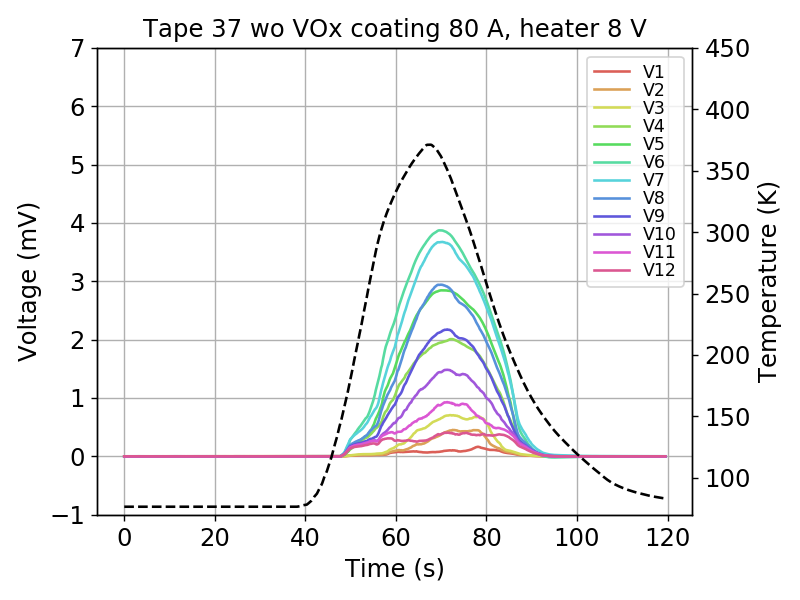

V_heater 8 : Max V7 = 0.00366043405946189 V, index 352
[8.58536419e-05 3.89916156e-04 6.66186968e-04 1.95909932e-03
 2.84538017e-03 3.86958911e-03 3.67417717e-03 2.93841252e-03
 2.15479249e-03 1.45952002e-03 9.05978414e-04 3.93213019e-04]


<IPython.core.display.Javascript object>


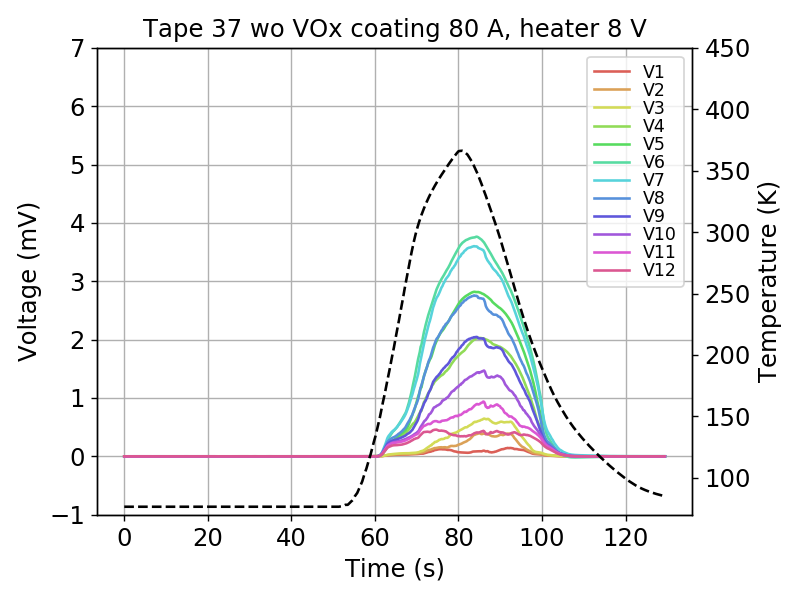

V_heater 8 : Max V7 = 0.00358891666145387 V, index 419
[8.20483448e-05 3.65213759e-04 5.84733583e-04 1.99633271e-03
 2.81925723e-03 3.75138895e-03 3.60278721e-03 2.75784085e-03
 2.04263109e-03 1.40144628e-03 8.62669876e-04 3.93021009e-04]


<IPython.core.display.Javascript object>


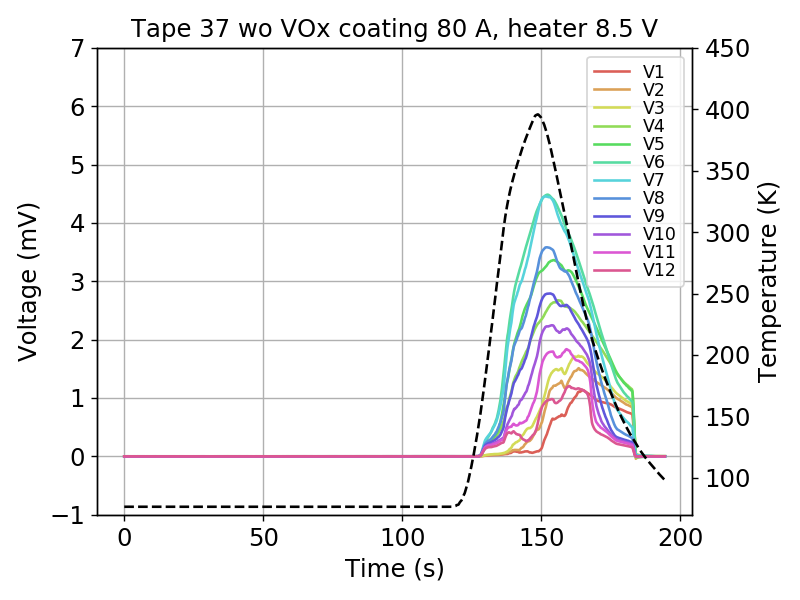

V_heater 8.5 : Max V7 = 0.00444256700896036 V, index 758
[0.00031555 0.00081506 0.00108776 0.0024557  0.00324369 0.00447009
 0.00445637 0.00357862 0.00277524 0.00221413 0.00172119 0.00092915]


<IPython.core.display.Javascript object>


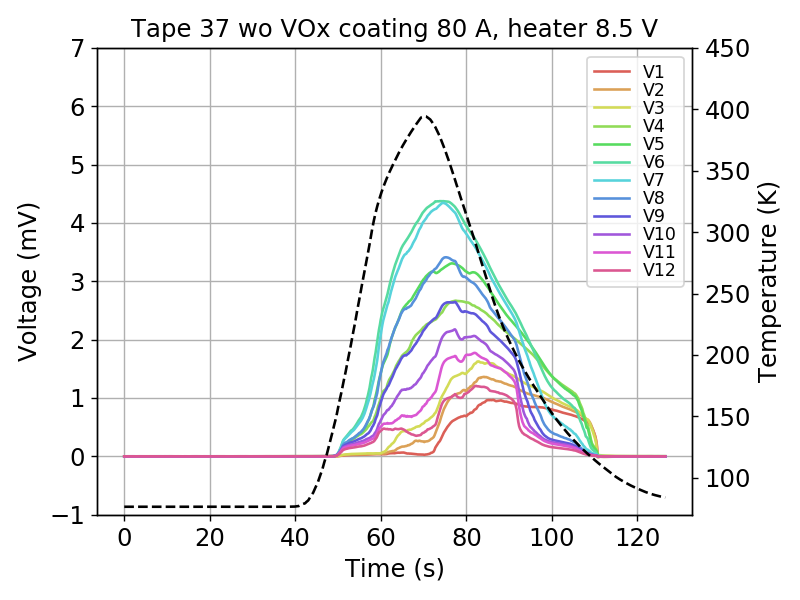

V_heater 8.5 : Max V7 = 0.004329152347495421 V, index 374
[0.00040822 0.00080998 0.00108652 0.00252541 0.00323355 0.00437237
 0.00434275 0.00340426 0.00261178 0.00208213 0.0016124  0.0009517 ]


<IPython.core.display.Javascript object>


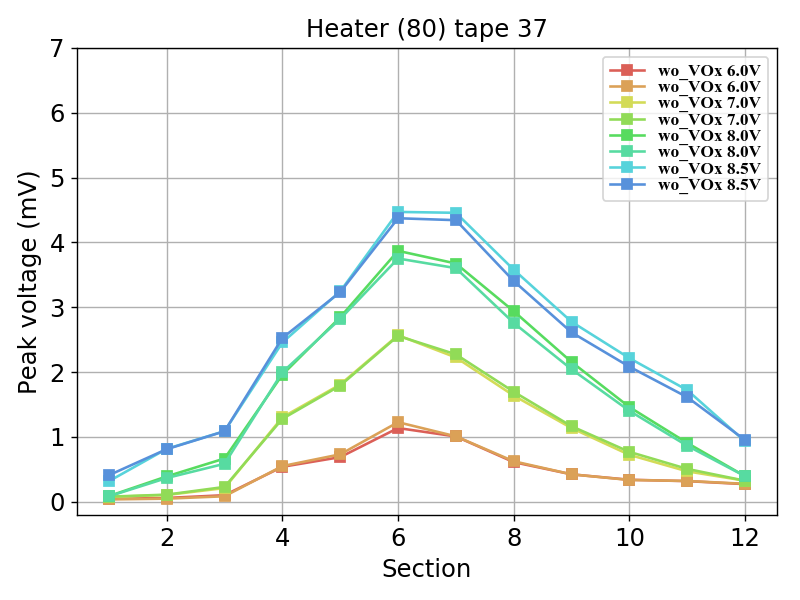

In [9]:
sns.set_palette(sns.color_palette("hls", 12))
tape_number = 37
current_percent = 80
coating = 'wo'
filename_wo = f'Tape {tape_number} heater {current_percent} A peak voltages without coating.txt'

Vheater = [6,6,7,7,8,8,8.5,8.5]
file_csv = [
'tape37_w_cu_thin_2020-02-11-14-22-55.csv',
'tape37_w_cu_thin_2020-02-11-14-35-58.csv',
'tape37_w_cu_thin_2020-02-11-14-48-22.csv',
'tape37_w_cu_thin_2020-02-11-15-11-01.csv',
'tape37_w_cu_thin_2020-02-11-15-25-00.csv',
'tape37_w_cu_thin_2020-02-11-15-38-20.csv',
'tape37_w_cu_thin_2020-02-11-15-50-27.csv',
'tape37_w_cu_thin_2020-02-11-16-04-13.csv'
]


for i in range(len(file_csv)):
    filenumber = i
    main(file_csv[i],tape_number,Vheater[i],filenumber,current_percent,filename_wo,coating)
    
    
v_profile_plot(filename_wo)

<IPython.core.display.Javascript object>


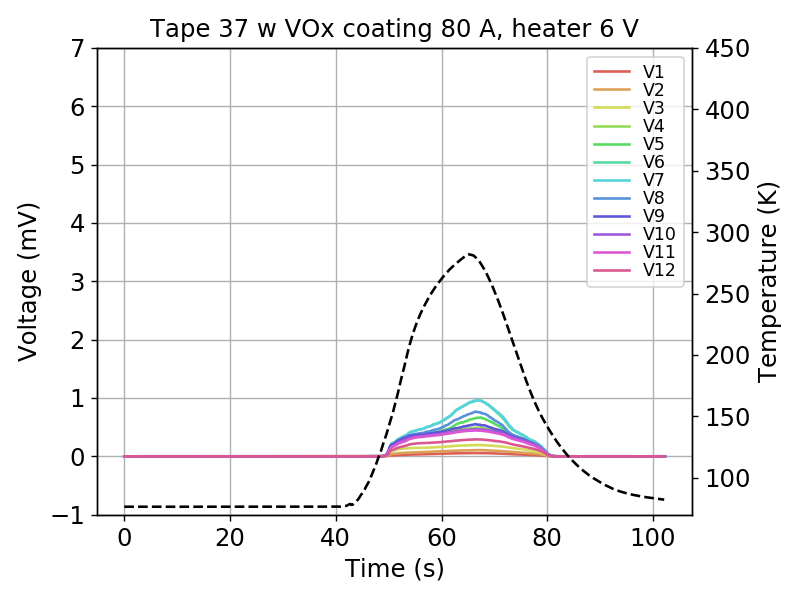

V_heater 6 : Max V7 = 0.000948149032410478 V, index 334
[5.52813749e-05 1.06248028e-04 1.92618803e-04 4.88186659e-04
 6.63876194e-04 9.59206632e-04 9.61720312e-04 7.61592163e-04
 5.42194171e-04 4.63643193e-04 4.40972624e-04 2.88976559e-04]


<IPython.core.display.Javascript object>


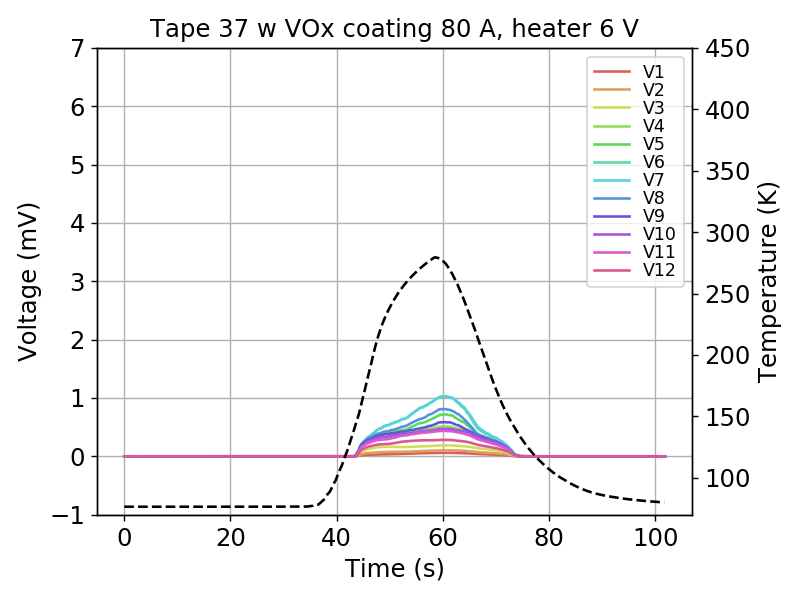

V_heater 6 : Max V7 = 0.0010160254189480599 V, index 304
[5.98260723e-05 1.03696030e-04 1.87561017e-04 5.09924331e-04
 7.18006473e-04 1.02737009e-03 1.02942244e-03 8.04733891e-04
 5.84808809e-04 4.70354322e-04 4.34955768e-04 2.81752082e-04]


<IPython.core.display.Javascript object>


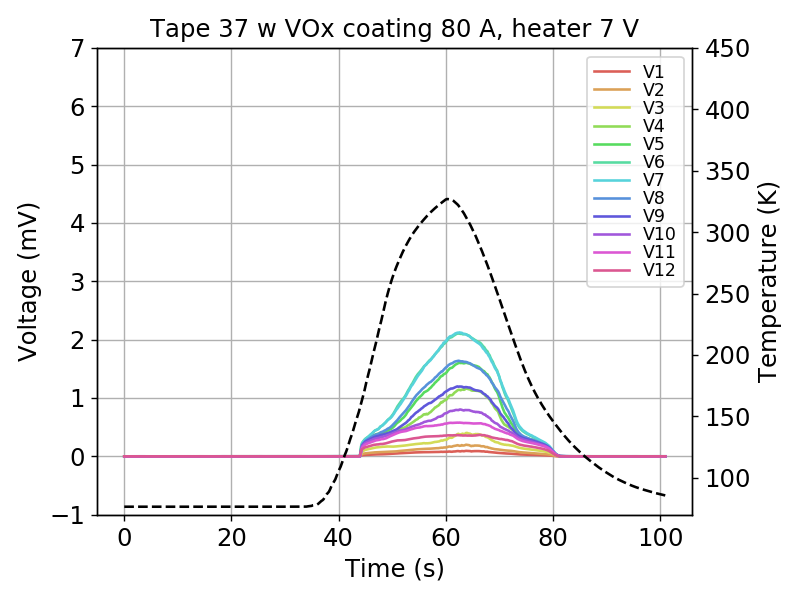

V_heater 7 : Max V7 = 0.00211031602900894 V, index 313
[8.54170113e-05 1.80016504e-04 3.69987475e-04 1.13916056e-03
 1.60326292e-03 2.10216423e-03 2.12383230e-03 1.63423821e-03
 1.19612334e-03 8.01337613e-04 5.77642011e-04 3.60219199e-04]


<IPython.core.display.Javascript object>


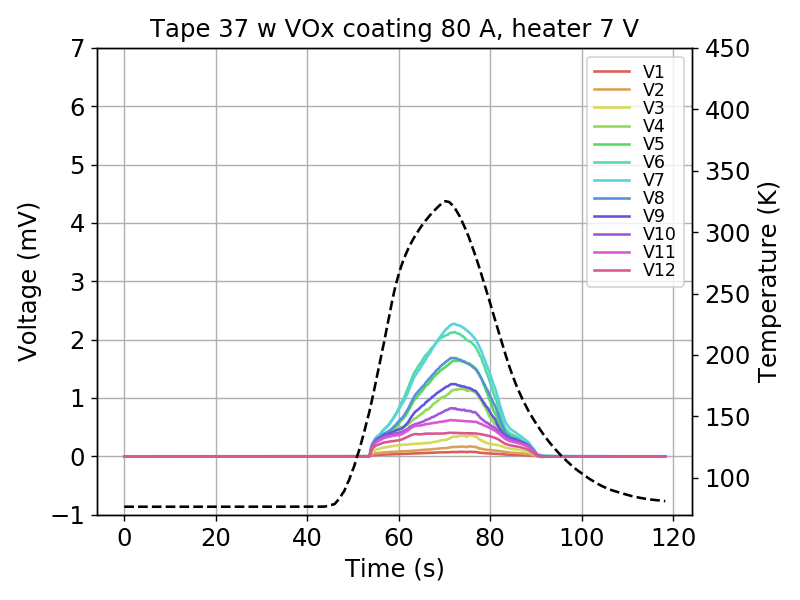

V_heater 7 : Max V7 = 0.00225762694042346 V, index 362
[7.34848980e-05 1.60781638e-04 3.37336407e-04 1.14266902e-03
 1.63989360e-03 2.12806487e-03 2.27112357e-03 1.68425690e-03
 1.23601554e-03 8.21522311e-04 6.17111599e-04 4.02934474e-04]


<IPython.core.display.Javascript object>


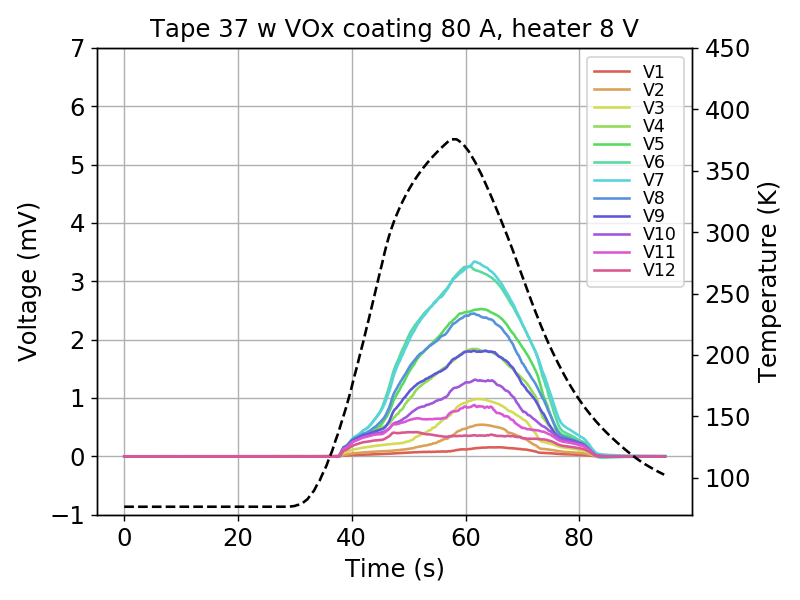

V_heater 8 : Max V7 = 0.0033236642463937397 V, index 308
[0.00013625 0.00052563 0.00097429 0.00183783 0.00251196 0.00319963
 0.00333707 0.00244688 0.00180637 0.00131177 0.00087984 0.00036215]


<IPython.core.display.Javascript object>


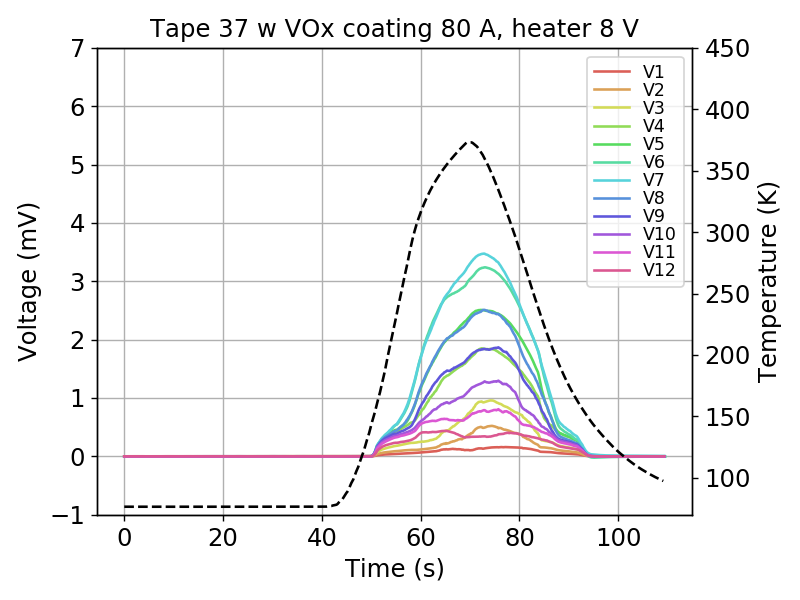

V_heater 8 : Max V7 = 0.00346028994665363 V, index 364
[0.00013165 0.00048816 0.00092397 0.00184274 0.00250472 0.00323491
 0.00347369 0.00250855 0.0018404  0.00127121 0.00079003 0.00034338]


<IPython.core.display.Javascript object>


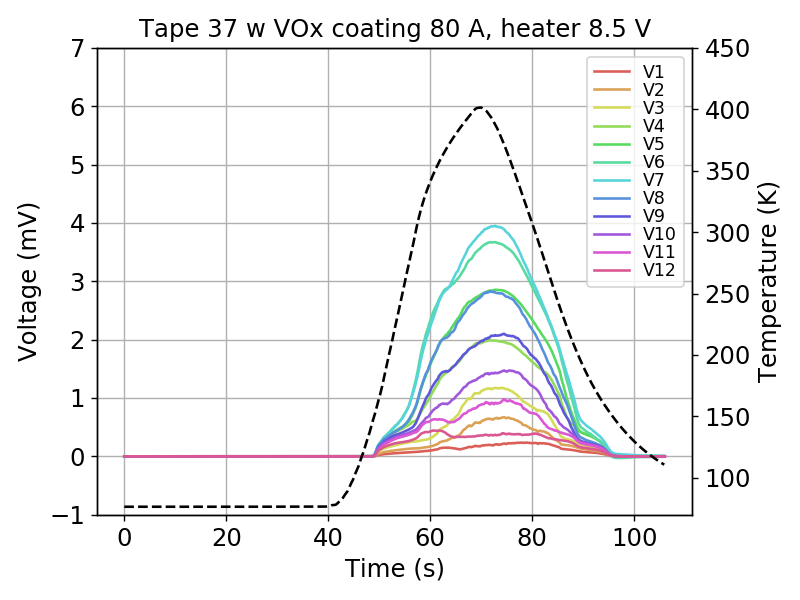

V_heater 8.5 : Max V7 = 0.0039382146913296105 V, index 364
[0.00020306 0.00065288 0.00117276 0.00198442 0.00285431 0.00367046
 0.00395173 0.00280813 0.00207734 0.00143426 0.00091766 0.00037003]


<IPython.core.display.Javascript object>


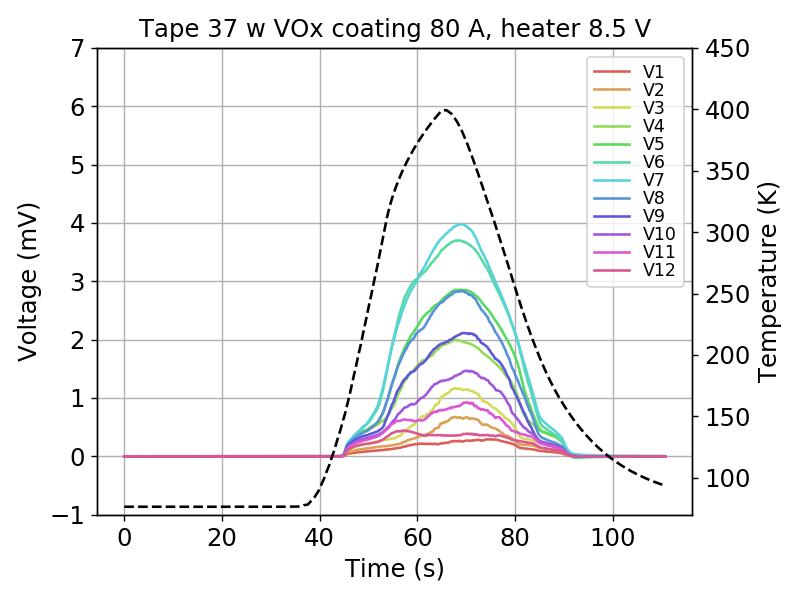

V_heater 8.5 : Max V7 = 0.00396345955137374 V, index 346
[0.00025329 0.00065093 0.00114105 0.00196891 0.00285014 0.00368634
 0.00397731 0.00283117 0.00210909 0.00143932 0.00089739 0.00037381]


<IPython.core.display.Javascript object>


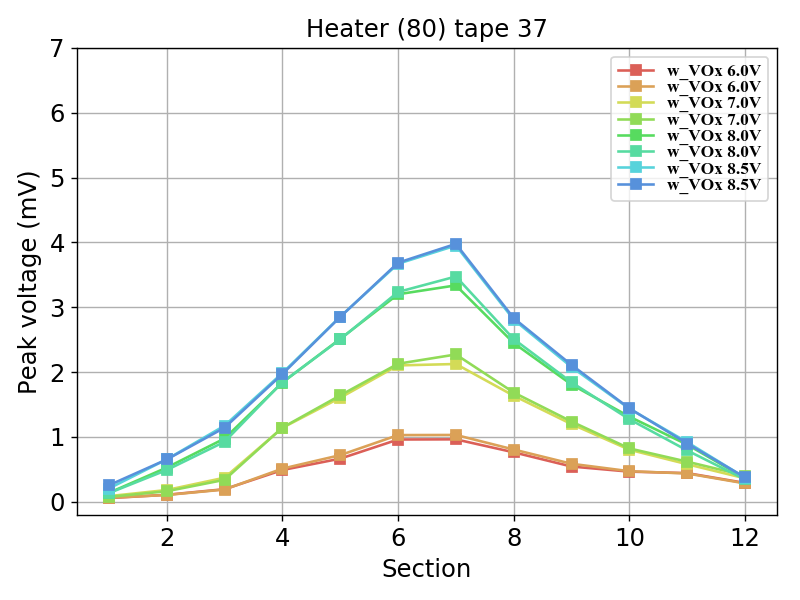

In [10]:
tape_number = 37
current_percent = 80
coating = 'w'
filename_w = f'Tape {tape_number} heater {current_percent} A peak voltages with coating.txt'

Vheater = [6,6,7,7,8,8,8.5,8.5] #[6,6,7,7,8,8,8.5]
file_csv = [
'tape37_w_cu_coating_2020-02-18-15-19-21.csv',
'tape37_w_cu_coating_2020-02-18-15-34-13.csv',
'tape37_w_cu_coating_2020-02-18-15-49-47.csv',
'tape37_w_cu_coating_2020-02-18-16-04-46.csv',
'tape37_w_cu_coating_2020-02-18-16-19-53.csv',
'tape37_w_cu_coating_2020-02-18-16-32-04.csv',
'tape37_w_cu_coating_2020-02-18-16-45-48.csv',
'tape37_w_cu_coating_2020-02-18-16-59-18.csv'
]


for i in range(len(file_csv)):
    filenumber = i
    main(file_csv[i],tape_number,Vheater[i],filenumber,current_percent,filename_w,coating)
    
    
v_profile_plot(filename_w)

<IPython.core.display.Javascript object>


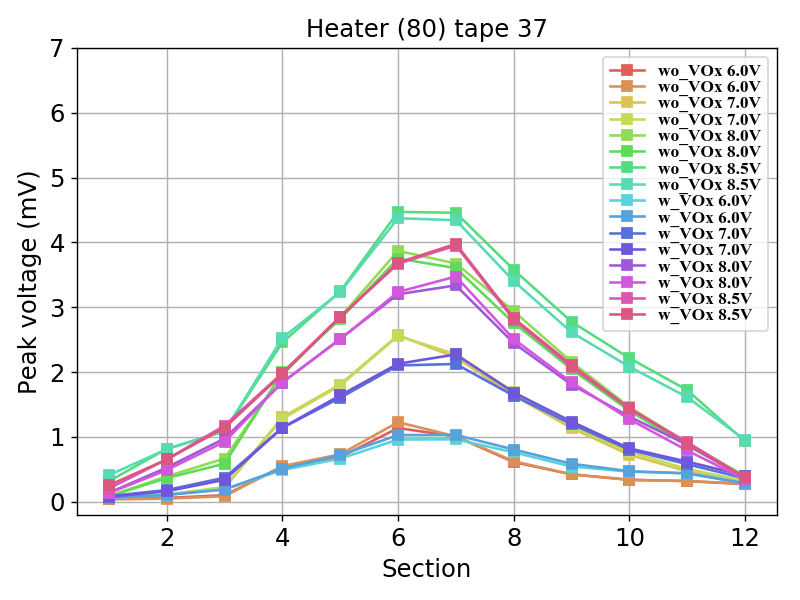

In [11]:
sns.set_palette(sns.color_palette("hls", 16))
fig,ax = plt.subplots()
v_profile_plot2(filename_wo,'wo')
v_profile_plot2(filename_w,'w')
plt.grid()
plt.show()